In [1]:
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from pandas.tools.plotting import parallel_coordinates
import pandas as pd
from sklearn import svm

from sklearn.metrics import jaccard_similarity_score

#from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

random_state = 100
#import xgboost as xgb

import pickle
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.model_selection import cross_val_score

In [2]:
#IMPORT DATA
data = pickle.load( open( "data/initial_features.pkl", "rb" ))
labels = pickle.load(open("data/initial_labels.pkl", "rb"))


#y = labels.values

In [3]:
# create training and testing vars
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.3)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(5338, 14) (5338, 1)
(2288, 14) (2288, 1)


In [ ]:
#CV SVM train
#clf = svm.SVC(kernel='linear', C=100)
#scores = cross_val_score(clf, X_train, np.ravel(Y_train), cv=10)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#scores = np.dot(X_train, clf.coef_.T)
#b0 = Y_train==0 # boolean or "mask" index arrays
#b1 = Y_train==1
#malignant_scores = scores[b1]
#benign_scores = scores[b0]

#fig  = plt.figure()
#fig.suptitle("score breakdown by classification", fontsize=14, fontweight='bold')
#score_box_plt = plt.boxplot(
#    [malignant_scores, benign_scores],
#    notch=True,
#    labels=[0,1],
#    vert=False
#)
#plt.show(score_box_plt)   

### SVM

In [ ]:
lin_clf = svm.SVC(kernel='linear')
lin_clf.fit(X_train,Y_train)

scores = np.dot(X_train, lin_clf.coef_.T)

b0 = Y_train==0 # boolean or "mask" index arrays
b1 = Y_train==1
malignant_scores = scores[b1]
benign_scores = scores[b0]

fig  = plt.figure()
fig.suptitle("score breakdown by classification", fontsize=14, fontweight='bold')
score_box_plt = plt.boxplot(
    [malignant_scores, benign_scores],
    notch=True,
    labels=[0,1],
    vert=False
)
plt.show(score_box_plt) 

# get the predictions
probas_ = lin_clf.predict(X_test)
            
# turn the predictions into correct format
probas_ = np.array([(1-x, x) for x in probas_])

# create roc curve
probs = lin_clf.predict(X_test)
preds = probs
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Get contributing features on (SVM) classification for a selected example

In [ ]:

selected_example = data.values[3]

lin_clf.predict(selected_example.reshape(1,14))

contributions = np.multiply(selected_example, lin_clf.coef_.reshape((14,)))
feature_number = np.arange(len(contributions)) +1

features_coefficients = dict(zip(list(data), contributions))
#print(features_coefficients)

plt.bar(list(data), contributions, align='center')
plt.xticks(list(data), rotation='vertical')
plt.xlabel('feature index')
plt.ylabel('score contribution')
plt.title('contribution to classification outcome by feature index')
plt.show()

# Sort features

#abs_contributions = np.flip(np.sort(np.absolute(contributions)), axis=0)
#feat_and_contrib = []
#for contrib in abs_contributions:
#    if contrib not in contributions:
#        contrib = -contrib
#        feat = np.where(contributions == contrib)
#        feat_and_contrib.append((feat[0][0], contrib))
#    else:
#        feat = np.where(contributions == contrib)
#        feat_and_contrib.append((feat[0][0], contrib))

# sorted by max abs value. each row a tuple:;(feature index, contrib)
print("Sorted features by max value :")
#feat_and_contrib
sorted(features_coefficients.items(), key=lambda t: t[1], reverse=True)

#### SVM Stratified k-fold (k = 10)

In [ ]:

scores = []
XX, YY = X_train, Y_train
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10)
#print(XX.iloc[50])
for train_index, test_index in skf.split(XX, YY):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_ttrain, X_ttest = XX.iloc[train_index], XX.iloc[test_index]
    y_ttrain, y_ttest = YY.iloc[train_index], YY.iloc[test_index]
    svm_test = svm.SVC(kernel='linear')
    svm_test.fit(X_ttrain,np.ravel(y_ttrain))
    
    # get the predictions
    probas_ = svm_test.predict(X_ttest)
            
    # turn the predictions into correct format
    probas_ = np.array([(1-x, x) for x in probas_])

    # create roc curve
    probs = svm_test.predict(X_ttest)
    preds = probs
    fpr, tpr, threshold = metrics.roc_curve(np.ravel(y_ttest), preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    print("AUC: "+str(roc_auc))
    scores.append(roc_auc)
print("The mean value of the scores is: ", np.mean(scores))

# Random Forest

In [6]:
# Hyperparameter Optimization for random forest
from scipy.stats import randint as sp_randint

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from time import time

# initialize the classifier
clf_RF = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=100)

# find the number of features for parameter optimization
num_features = X_train.shape[1]

# make scorer
auc_scorer = make_scorer(roc_auc_score, needs_threshold=True)#, needs_proba=True

# params
m_depths = [None] + list(range(2, 21, 3))

# specify parameters and distributions to sample from
param_dist_rf = {"max_depth": m_depths, # [None, 2, 5, 8, 11, 14, 17, 20]
                 "max_features": sp_randint(1, num_features),
                 "min_samples_split": sp_randint(2, 100),
                 "min_samples_leaf": sp_randint(1, 100),
                 "bootstrap": [True, False],
                 "criterion": ["gini", "entropy"]}

n_iter_search = 30 # was 20

# run randomized search
random_search_RF = RandomizedSearchCV(clf_RF, 
                                      param_distributions=param_dist_rf,
                                      n_iter=n_iter_search,
                                      scoring=auc_scorer,
                                      random_state=random_state,
                                      n_jobs=-1,
                                      return_train_score=True)

start = time()
random_search_RF.fit(X_train, Y_train)
print("RandomizedSearchCV took {:.2f} seconds for {} candidates"
      " parameter settings.\n".format((time() - start), n_iter_search))

# display the dataframe without the parameters column for better rendering
display(pd.DataFrame(random_search_RF.cv_results_).drop('params', axis=1))

best_parameters_RF = pd.Series(random_search_RF.best_params_)

# display the best set of parameters
display(best_parameters_RF)


/Users/manolis/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV took 7.92 seconds for 30 candidates parameter settings.



/Users/manolis/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.120821,0.108009,0.983291,0.984870,True,gini,8,8,88,81,...,0.989280,0.983113,0.983506,0.985545,0.977083,0.985953,0.003632,0.001031,0.004982,0.001254
1,0.115648,0.107668,0.978740,0.980779,True,gini,17,5,99,55,...,0.983971,0.977826,0.980541,0.981878,0.971704,0.982634,0.005045,0.002097,0.005168,0.002111
2,0.112304,0.108524,0.990211,0.992750,True,gini,17,3,25,17,...,0.995138,0.991115,0.990710,0.992800,0.984783,0.994337,0.002527,0.003561,0.004242,0.001316
3,0.119475,0.108963,0.994136,0.997016,True,entropy,11,11,17,11,...,0.997218,0.996485,0.994208,0.996939,0.990981,0.997626,0.004344,0.002867,0.002547,0.000469
4,0.113060,0.109270,0.988484,0.992103,False,gini,5,12,5,33,...,0.993248,0.990217,0.989345,0.991238,0.982855,0.994854,0.001792,0.001313,0.004287,0.001989
5,0.115207,0.107431,0.993561,0.997147,False,entropy,14,4,5,93,...,0.997675,0.996355,0.994633,0.997417,0.988374,0.997669,0.006823,0.001370,0.003872,0.000570
6,0.111823,0.108897,0.987300,0.989261,False,entropy,20,2,48,67,...,0.992420,0.987583,0.989208,0.990021,0.980269,0.990179,0.001613,0.001317,0.005141,0.001188
7,0.113347,0.107501,0.988762,0.990830,False,gini,20,8,81,4,...,0.993089,0.989636,0.989500,0.991346,0.983694,0.991508,0.000699,0.001849,0.003871,0.000847
8,0.112933,0.107676,0.986857,0.989106,False,entropy,17,4,99,65,...,0.992094,0.987377,0.987171,0.989347,0.981302,0.990596,0.002638,0.001051,0.004412,0.001325
9,0.114020,0.108828,0.989967,0.993075,False,entropy,None,2,31,50,...,0.994651,0.990889,0.990134,0.993104,0.985114,0.995233,0.000551,0.003346,0.003895,0.001774


bootstrap               True
criterion            entropy
max_depth                 11
max_features              11
min_samples_leaf          17
min_samples_split         11
dtype: object

/Users/manolis/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


train accuracy: 0.979955039340577
test accuracy: 0.9729020979020979


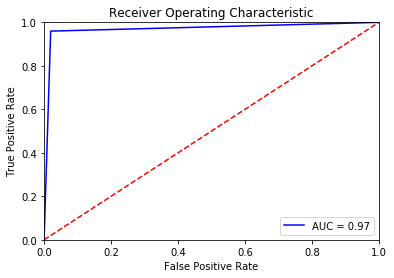

In [7]:
#Train optimized random forest
model7 = RandomForestClassifier(n_estimators=10 ,
                                min_samples_split= 11,
                                min_samples_leaf=17,
                                bootstrap = True,
                                criterion = 'entropy',
                                max_depth = 11,
                                max_features = 11,
                                n_jobs=-1,
                                random_state=100)
model7.fit(X_train, Y_train)
print('train accuracy: '+str(jaccard_similarity_score(model7.predict(X_train), Y_train)))
print('test accuracy: '+str(jaccard_similarity_score(model7.predict(X_test), Y_test)))

# create roc curve
probs = model7.predict(X_test)
preds = probs
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Random forest global feature importance
Find the most important features in the whole dataset (including train and test set)

In [ ]:
#
importances = model7.feature_importances_
std = np.std([tree.feature_importances_ for tree in model7.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(data.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(data.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(data.shape[1]), indices)
plt.xlim([-1, data.shape[1]])
plt.show()

### Get contributing features in a (RF) signle prediction

In [ ]:
import eli5
#eli5.show_prediction(model7, selected_example, feature_names=list(data))
eli5.explain_prediction(model7, selected_example, feature_names=list(data))

## XGBoost

In [ ]:
import xgboost as xgb
best_params = {"eta": None,
               "min_child_weight": None,
               "gamma": None,
               "max_depth": None,
               "max_delta_step": None,
               "subsample": None,
               "colsample_bytree": None,
               "lambda": None,
               "objective": None}

number_of_iterations = {"after_tree_params": None,
                        "after_reg_params": None,
                        "after_function_param": None,
                        "after_eta": None}

In [ ]:

np.random.seed(random_state)

best_score = 0.0

num_iterations = 20

max_iterations = []

# get data into the correct format
xgbData = xgb.DMatrix(X_train, label=Y_train)

# prepare parameters
maxDepths = np.random.randint(3, 40, size=num_iterations)
minChildWeights = np.random.randint(0, 40, size=num_iterations)
gammas = np.random.randint(3, 50, size=num_iterations)
maxDeltaStep = np.random.randint(0, 10, size=num_iterations)

params_tupled = [(a, b, c, d) for a, b, c, d in zip(maxDepths,
                                                    minChildWeights,
                                                    gammas,
                                                    maxDeltaStep)]

# specify parameters and distributions to sample from
param_dist_XGB = {"eta": 0.3,
                  "min_child_weight": 1.0,
                  "gamma": 0.0,
                  "max_depth": 20,
                  "max_delta_step": 0.0,
                  "subsample": 0.8,
                  "colsample_bytree": 0.8,
                  "lambda": 1,
                  "objective": "binary:logistic"}

for mD, mCW ,g ,mDS in params_tupled:
    
    param_dist_XGB["max_depth"] = mD
    param_dist_XGB["min_child_weight"] = mCW
    param_dist_XGB["gamma"] = g
    param_dist_XGB["max_delta_step"] = mDS

    # get a cross validated result
    cv_XGB = xgb.cv(param_dist_XGB,
                    xgbData,
                    num_boost_round=300,
                    seed=random_state,
                    nfold=5,
                    stratified=True,
                    metrics={'auc'},
                    early_stopping_rounds=30,
                    as_pandas=True,
                    shuffle=False)
    
    # get the smallest score
    mean_auc_test_score = cv_XGB['test-auc-mean'].max()
    
    print("The highest auc score of the cross validation is {}.".format(mean_auc_test_score))
    
    if mean_auc_test_score < 0.85:
        print(" -> its params were: max_depth={}, min_child_weight={}, gamma={}, max_delta_step={}"
              .format(mD, mCW, g, mDS))
    
    max_iterations.append(cv_XGB.index.values[-1] + 1)
    
    if mean_auc_test_score > best_score:
        
        # update the smallest error
        best_score = mean_auc_test_score
        # update best parameters
        best_params["max_depth"] = mD
        best_params["min_child_weight"] = mCW
        best_params["gamma"] = g
        best_params["max_delta_step"] = mDS

number_of_iterations["after_tree_params"] = max(max_iterations)

print()
print("The optimal max_depth was found to be: {}".format(best_params["max_depth"]))
print("The optimal min_child_weight was found to be: {}".format(best_params["min_child_weight"]))
print("The optimal gamma was found to be: {}".format(best_params["gamma"]))
print("The optimal max_delta_step was found to be: {}\n".format(best_params["max_delta_step"]))

print("The best auc score for the best tree parameters is {}.\n".format(best_score))

print("The number of iterations for the train cases were {}, and the max of them is {}."
      .format(max_iterations, number_of_iterations["after_tree_params"]))

In [ ]:
best_score = 0.0

num_iterations = 20

max_iterations = []

# prepare parameters
subsampleParam = np.random.uniform(0.1, 1, size=num_iterations)
colsample_bytreeParam = np.random.uniform(0.1, 1, size=num_iterations)
lambdaParam = np.random.randint(1, 5, size=num_iterations)

params_tupled = [(a, b, c) for a, b, c in zip(subsampleParam,
                                              colsample_bytreeParam,
                                              lambdaParam)]

# specify parameters and distributions to sample from
param_dist_XGB = {"eta": 0.3,
                  "min_child_weight": best_params["min_child_weight"],
                  "gamma": best_params["gamma"],
                  "max_depth": best_params["max_depth"],
                  "max_delta_step": best_params["max_delta_step"],
                  "subsample": 0.8,
                  "colsample_bytree": 0.8,
                  "lambda": 1,
                  "objective": "binary:logistic"}

for ss, csbt ,l in params_tupled:
    
    param_dist_XGB["subsample"] = ss
    param_dist_XGB["colsample_bytree"] = csbt
    param_dist_XGB["lambda"] = l

    # get a cross validated result
    cv_XGB = xgb.cv(param_dist_XGB,
                    xgbData,
                    num_boost_round=300,
                    seed=random_state,
                    nfold=5,
                    stratified=True,
                    metrics={'auc'},
                    early_stopping_rounds=30,
                    as_pandas=True,
                    shuffle=False)
    
    # get the smallest score
    mean_auc_test_score = cv_XGB['test-auc-mean'].max()
    
    print("The smallest auc score of the cross validation is {}.".format(mean_auc_test_score))
    
    if mean_auc_test_score < 0.85:
        print("  -> its parameters were: subsample={}, colsample_bytree={}, lambda={}."
              .format(ss, csbt, l))
        
    max_iterations.append(cv_XGB.index.values[-1] + 1)
    
    if mean_auc_test_score > best_score:
        
        # update the smallest error
        best_score = mean_auc_test_score
        # update best parameters
        best_params["subsample"] = ss
        best_params["colsample_bytree"] = csbt
        best_params["lambda"] = l

number_of_iterations["after_reg_params"] = max(max_iterations)

print()
print("The optimal subsample was found to be: {}".format(best_params["subsample"]))
print("The optimal colsample_bytree was found to be: {}".format(best_params["colsample_bytree"]))
print("The optimal lambda was found to be: {}\n".format(best_params["lambda"]))

print("The best auc score for the best tree parameters is {}.\n".format(best_score))

print("The number of iterations for the train cases were {}, and the max of them is {}."
      .format(max_iterations, number_of_iterations["after_reg_params"]))


In [ ]:
best_score = 0.0

max_iterations = []

params_tupled = ["binary:logistic", "binary:logitraw"]

# specify parameters and distributions to sample from
param_dist_XGB = {"eta": 0.3,
                  "min_child_weight": best_params["min_child_weight"],
                  "gamma": best_params["gamma"],
                  "max_depth": best_params["max_depth"],
                  "max_delta_step": best_params["max_delta_step"],
                  "subsample": best_params["subsample"],
                  "colsample_bytree": best_params["colsample_bytree"],
                  "lambda": best_params["lambda"],
                  "objective": None}

for func in params_tupled:
    
    param_dist_XGB["objective"] = func

    # get a cross validated result
    cv_XGB = xgb.cv(param_dist_XGB,
                    xgbData,
                    num_boost_round=300,
                    seed=random_state,
                    nfold=5,
                    stratified=True,
                    metrics={'auc'},
                    early_stopping_rounds=30,
                    as_pandas=True,
                    shuffle=False)
    
    # get the smallest score
    mean_auc_test_score = cv_XGB['test-auc-mean'].max()
    
    print("The smallest auc score of the cross validation is {}.".format(mean_auc_test_score))
    
    if mean_auc_test_score < 0.85:
        print("  -> its parameters were: function={}."
              .format(func))
        
    max_iterations.append(cv_XGB.index.values[-1] + 1)
    
    if mean_auc_test_score > best_score:
        
        # update the smallest error
        best_score = mean_auc_test_score
        # update best parameters
        best_params["objective"] = func

number_of_iterations["after_function_param"] = max(max_iterations)

print()
print("The optimal function was found to be: {}\n".format(best_params["objective"]))

print("The best auc score for the best tree parameters is {}.".format(best_score))

print("The number of iterations for the train cases were {}, and the max of them is {}."
      .format(max_iterations, number_of_iterations["after_function_param"]))


In [ ]:
best_score = 0.0

max_iterations = []

#params_tupled = np.arange(0.005, 0.5, 0.02)
params_tupled = np.arange(0.05, 1.0, 0.02)

# specify parameters and distributions to sample from
param_dist_XGB = {"eta": 0.1,
                  "min_child_weight": best_params["min_child_weight"],
                  "gamma": best_params["gamma"],
                  "max_depth": best_params["max_depth"],
                  "max_delta_step": best_params["max_delta_step"],
                  "subsample": best_params["subsample"],
                  "colsample_bytree": best_params["colsample_bytree"],
                  "lambda": best_params["lambda"],
                  "objective": best_params["objective"]}

for eta in params_tupled:
    
    param_dist_XGB["eta"] = eta

    # get a cross validated result
    cv_XGB = xgb.cv(param_dist_XGB,
                    xgbData,
                    num_boost_round=300,
                    seed=random_state,
                    nfold=5,
                    stratified=True,
                    metrics={'auc'},
                    early_stopping_rounds=30,
                    as_pandas=True,
                    shuffle=False)
    
    # get the smallest score
    mean_auc_test_score = cv_XGB['test-auc-mean'].max()
    
    print("The smallest auc score of the cross validation is {}.".format(mean_auc_test_score))
    
    if mean_auc_test_score < 0.85:
        print("The eta was {}.".format(eta))
        
    max_iterations.append(cv_XGB.index.values[-1] + 1)
    
    if mean_auc_test_score > best_score:
        
        # update the smallest error
        best_score = mean_auc_test_score
        # update best parameters
        best_params["eta"] = eta

number_of_iterations["after_eta"] = max(max_iterations)

print()
print("The eta parameter was found to be: {}\n".format(best_params["eta"]))

print("The best auc score for the best tree parameters is {}.".format(best_score))

print("The number of iterations for the train cases were {}, and the max of them is {}."
      .format(max_iterations, number_of_iterations["after_eta"]))


In [ ]:
best_clf_XGB = xgb
print("The best XGB classifier is:\n\n{}\n".format(best_clf_XGB))

In [ ]:
print("The best set of parameters for the XGB classifier are:\n")

display(pd.Series(best_params))

In [ ]:
from scipy import interp
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc
import time
np.set_printoptions(threshold=400)

def make_and_plot_AUROC(clf, XX, yy, n_folds=10, RF=True, shuffle=True, save_name=''):
    """ Calculates the mean AUROC and plots it."""

    #start = time()
    
    # initialize the cross validation object for 10 folds
    cv = StratifiedKFold(n_splits=n_folds, shuffle=shuffle, random_state=0)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    feature_scores = []

    fig = plt.figure()
    ax = plt.subplot(111)

    fig.set_figwidth(8)
    fig.set_figheight(6)

    i = 0
    for train, test in cv.split(XX, yy):
        
        if RF:
            probas_ = clf.fit(XX[train], yy[train]).predict_proba(XX[test])
        else:
            # prep the data
            data_train = xgb.DMatrix(XX[train], label=yy[train])
            data_test = xgb.DMatrix(XX[test], label=yy[test])
                        
            # get the booster instance after training
            model = clf.train(best_params, data_train, 
                              number_of_iterations["after_function_param"]+5)
            
            # get the predictions
            probas_ = model.predict(data_test)
            
            # turn the predictions into correct format
            probas_ = np.array([(1-x, x) for x in probas_])
            
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(yy[test], probas_[:, 1], pos_label=1)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('AUROC curves of the {} folds and their mean curve.'.format(n_folds))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if save_name:
        pass
        #plt.savefig('images/ROC visualization of {} for {} folds.png'.format(save_name, n_folds), 
                    #bbox_inches='tight')
    plt.show()
    
    print("The full auc score is {}.".format(mean_auc))
    print("The std of the mean auc score is {}.\n".format(std_auc))
    
    #print("The time it took for making and plotting the mean curve is {}.".format(time() - start))

In [ ]:
# use make_and_plot_AUROC with XGB
make_and_plot_AUROC(best_clf_XGB, X_train, Y_train, RF=False, shuffle=False, save_name='XGB')